# Projet 10: Détection des faux billets avec Python


## 1. Preliminary

Contexte : 

* Identification des contrefaçons des billets en euros
* Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

## A. Importation des librairies

In [132]:
#builtin
import os

In [133]:
#data
import pandas as pd
import numpy as np

In [134]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [135]:
#stat
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [136]:
#machine learning
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
from sklearn.cluster import KMeans

## B. chargement des fichiers

In [137]:
input_folder = "../data/source/"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')

## 2. Prétraitement des données

## 2.1 Exploration

In [138]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [139]:
BVF = train_df.pivot_table(index=["is_genuine"], aggfunc='mean')
BVF

,diagonal,height_left,height_right,length,margin_low,margin_up
is_genuine,,,,,,
0.0,171.90116,104.19034,104.14362,111.63064,5.215935,3.35016
1.0,171.98708,103.94913,103.80865,113.20243,4.116097,3.05213


In [140]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(train_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 1500.


In [141]:
# preview test data
test_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


test DataFrame contient 5 lignes sans valeurs manquantes.

In [142]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(test_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 5.


Note: On ne voit pas la colonne 'is_genuine' (la target) dans le dataset test_df. Notre objectif est alors de prédire la target par differentes algorithmes de machine learning comme la regression logistique.

### Transform is_geniune into is_fake (revserse 0 and 1)

In [143]:
train_df['is_fake'] = 1 - train_df['is_genuine']
train_df['is_fake'].astype(int)
train_df.drop(columns=['is_genuine'], inplace=True)

In [144]:
#Affichage des 5 dernieres lignes
train_df.tail()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
1495,171.75,104.38,104.17,4.42,3.09,111.28,1.0
1496,172.19,104.63,104.44,5.27,3.37,110.97,1.0
1497,171.80,104.01,104.12,5.51,3.36,111.95,1.0
1498,172.06,104.28,104.06,5.17,3.46,112.25,1.0
1499,171.47,104.15,103.82,4.63,3.37,112.07,1.0


In [145]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
1024,171.52,104.05,104.31,4.24,3.70,112.60,1.0
118,171.92,103.60,103.36,4.23,2.93,113.51,0.0
884,172.57,103.78,103.65,4.27,3.04,113.00,0.0
621,171.99,103.69,103.51,3.90,3.02,113.04,0.0
789,172.00,103.84,103.72,4.77,2.87,113.84,0.0


In [146]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [147]:
#Information sur les colonnes
train_df.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
is_fake         float64
dtype: object

In [148]:
#Statistiques descriptives
train_df.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_fake
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68,0.33
std,0.31,0.30,0.33,0.66,0.23,0.87,0.47
min,171.04,103.14,102.82,2.98,2.27,109.49,0.00
25%,171.75,103.82,103.71,4.01,2.99,112.03,0.00
50%,171.96,104.04,103.92,4.31,3.14,112.96,0.00
75%,172.17,104.23,104.15,4.87,3.31,113.34,1.00
max,173.01,104.88,104.95,6.90,3.91,114.44,1.00


In [149]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [150]:
#Nombre des doublons sans le target
train_df.drop(columns="is_fake").duplicated().sum()

0

In [151]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
is_fake           2
dtype: int64

In [152]:
#Nombre des valeurs dans la target
train_df['is_fake'].value_counts()

is_fake
0.0    1000
1.0     500
Name: count, dtype: int64

In [153]:
#creation de la colonne target
train_df.rename(columns={'is_fake':'target'}, inplace=True)

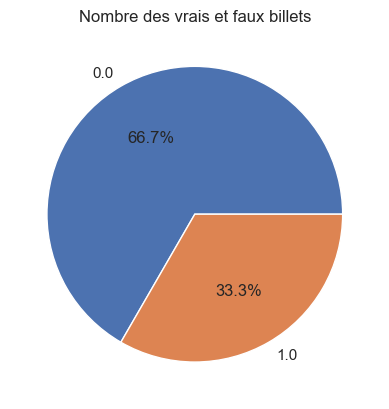

In [154]:
data=train_df['target'].value_counts()
labels=data.index
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Nombre des vrais et faux billets')
plt.show()

1=faux
0=vrai

## 2.2 Nettoyage des données

In [155]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
target           0
dtype: int64

In [156]:
#Nombre des valeurs manquantes dans chaque colonne
tmp = train_df.isnull().mean()
tmp[tmp > 0]

margin_low    0.024667
dtype: float64

On a 37 valeurs manquantes dans la colonne margin_low

In [157]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% des données dans la colonne margin_low est manquantes. -> voir la distribution de cette variable

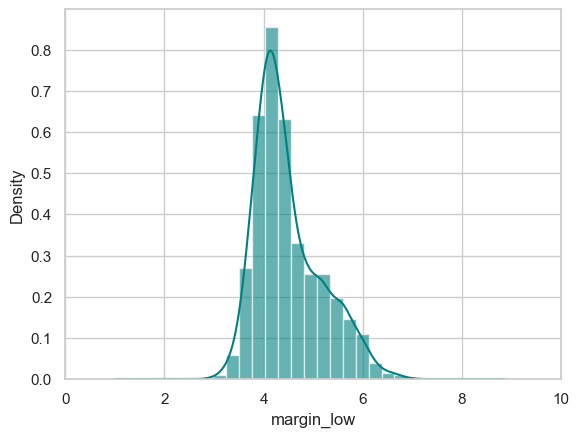

In [158]:
# la distribution de la variable 'margin_low'
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

### 2.3.1 Imputation des valeurs manquantes

In [263]:
train_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0


---> On a un DataFrame qui contient X=6 (features)

Les valeurs manquantes sont de type numerique

In [160]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= train_df[train_df['margin_low'].isna()] #DataFrame qui contient que des valeurs manquantes dans la colonne margin_low

train = train_df[~train_df['margin_low'].isna()] #dataframe sans valeurs manquantes

In [161]:
test.shape, train.shape

((37, 7), (1463, 7))

In [162]:
#les variables explicative (X)
X_train = train.drop(columns=['margin_low', 'target'])
X_train.head()

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54


In [163]:
# Création d'une instance de StandardScaler
scaler_1 = StandardScaler()
# Adapter le scaler aux données
scaler_1.fit(X_train)

# Standardiser les données
X_train_scaled = scaler_1.transform(X_train)
X_train_scaled[:5]

array([[-0.48859357,  2.76680735,  3.17376615, -1.13698239,  0.17784229],
       [-1.63480853, -2.24148961, -0.80685073, -0.7048056 ,  0.47569209],
       [ 2.39331832,  1.49803879, -1.30057066, -0.92089399,  0.55588243],
       [-1.96229852, -0.40511406,  0.05715913, -0.61837024,  0.95683409],
       [-0.75058556,  0.83026586, -1.42400064,  1.41286065, -0.15437481]])

In [164]:
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

## 2.3.2 Choix du modele 

In [165]:
# Initialiser les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Naive Model (median)': DummyRegressor(strategy='median'),
    'Naive Model (Mean)': DummyRegressor(strategy='mean')
}

# La validation croisée et les scores RMSE pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = (-scores) ** 0.5
    results[model_name] = {'mean_rmse': rmse_scores.mean(), 'std_rmse': rmse_scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean RMSE: {result['mean_rmse']}")
    print(f"Standard deviation of RMSE: {result['std_rmse']}\n")


Model: Linear Regression
Mean RMSE: 0.48164583801892374
Standard deviation of RMSE: 0.11550617228305045

Model: Naive Model (median)
Mean RMSE: 0.6822920177155671
Standard deviation of RMSE: 0.31702538904937455

Model: Naive Model (Mean)
Mean RMSE: 0.7213898563877186
Standard deviation of RMSE: 0.20682302212606174



Selon les métriques de RMSE (erreur), le modèle de régression linéaire démontre la meilleure performance parmi les trois modèles testés.

## A. Régression linéaire de Sklearn

In [166]:
# Créer et entraîner le modèle de régression linéaire
model_1 = LinearRegression()
model_1.fit(X_train_scaled, y_train)

LinearRegression()

In [167]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low', 'target'])

In [168]:
X_test.head()

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [169]:
# Standardisation des données de X_test
X_test_scaled = scaler_1.transform(X_test)
X_test_scaled[:5]

array([[-0.06285659, -0.47189135, -1.45485813,  0.41885404,  0.13201924],
       [-0.09560559,  0.12910429,  0.79773902, -0.05654042,  0.46423633],
       [ 0.3628804 , -0.77238917,  1.41488892, -0.57515256,  0.2923999 ],
       [-1.66755753, -1.23983022, -0.3748458 ,  2.01790815,  0.68189581],
       [-0.42309557,  0.36282481,  0.42744908, -0.57515256, -0.36057852]])

In [170]:
# Prédire les valeurs manquantes
y_predicted = model_1.predict(X_test_scaled)

In [171]:
y_predicted.shape

(37,)

In [172]:
y_predicted

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [173]:
#Creation d'une copy de notre DataFrame
df_reg=train_df.copy()

In [174]:
# Remplacement des valeurs manquantes par les valeurs prédites
df_reg.loc[df_reg['margin_low'].isna(), 'margin_low'] = y_predicted

In [175]:
#Verification
df_reg.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
target          0
dtype: int64

In [176]:
# preview adjusted train data
df_reg.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0


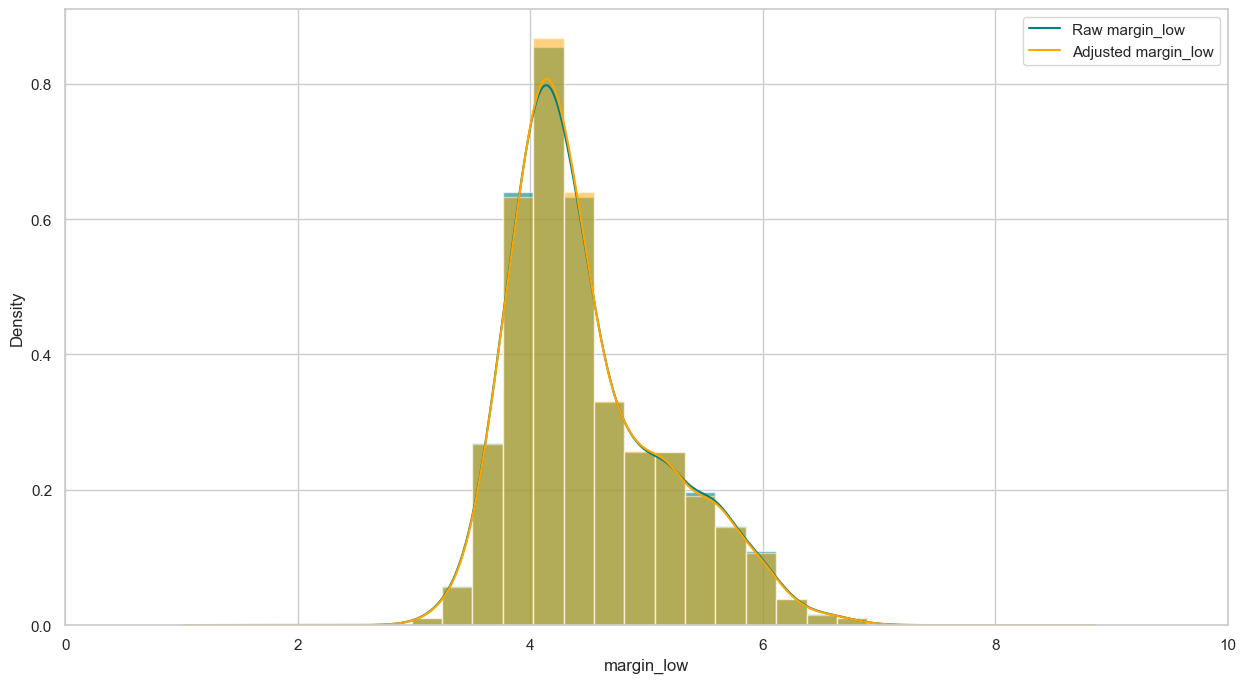

In [177]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_reg["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_reg["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

## B. La méthode de régression linéaire de Statsmodels

In [178]:
# Créer et ajuster le modèle aux données d'entraînement
model_2 = sm.OLS(y_train, X_train_scaled)
model_fit = model_2.fit()

# Faire des prédictions sur les données de test mises à l'échelle
predicted_values = model_fit.predict(X_test_scaled)

# Afficher les valeurs prédites
print(predicted_values)

[-0.16744253 -0.09229964 -0.07551056 -0.16695296  0.16464991 -0.68265889
 -0.30623111 -0.35852565 -0.35093301 -0.32542868 -0.30854693 -0.71741341
 -0.42720334 -0.1879201  -0.32535973 -0.39190266 -0.04612093 -0.01531682
 -0.14432397 -0.40555271 -0.87166131 -0.11415572 -0.39234651 -0.23633823
 -0.5922189  -0.73963454 -0.24855238  0.22456568 -0.34818697  0.56430996
  0.31617803  0.58161681  0.56160248  0.29299998  1.24102581  0.69989494
  0.6540755 ]


Avec Statsmodels, on doit ajouter manuellement une colonne qui contient une constante

In [179]:
#On a besoin d'une constante dans ce maodéle
X_train_scaled_with_const = sm.add_constant(X_train_scaled)
X_test_scaled_with_const = sm.add_constant(X_test_scaled)
X_test_scaled_with_const[:5]

array([[ 1.        , -0.06285659, -0.47189135, -1.45485813,  0.41885404,
         0.13201924],
       [ 1.        , -0.09560559,  0.12910429,  0.79773902, -0.05654042,
         0.46423633],
       [ 1.        ,  0.3628804 , -0.77238917,  1.41488892, -0.57515256,
         0.2923999 ],
       [ 1.        , -1.66755753, -1.23983022, -0.3748458 ,  2.01790815,
         0.68189581],
       [ 1.        , -0.42309557,  0.36282481,  0.42744908, -0.57515256,
        -0.36057852]])

In [180]:
model_2 = sm.OLS(y_train, X_train_scaled_with_const).fit()

In [181]:
model_2.params

const    4.485967
x1      -0.033912
x2       0.055145
x3       0.083331
x4       0.059278
x5      -0.357115
dtype: float64

In [182]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 28 Mar 2024   Prob (F-statistic):          2.60e-202
Time:                        13:47:51   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4860      0.013    356.926      0.000       4.461       4.511
x1            -0.0339      0.013     -2.680      0.007      -0.059      -0.009
x2             0.0551      0.013      4.113      0.000       0.029       0.081
x3             0.0833      0.014      5.978      0.000       0.056       0.111
x4             0.0593      0.015      3.980      0.000       0.030       0.088
x5            -0.3571      0.016    -22.627      0.000      -0.388      -0.326
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                         2.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
model_2.pvalues

const    0.000000e+00
x1       7.443859e-03
x2       4.132146e-05
x3       2.836546e-09
x4       7.233463e-05
x5       2.183858e-97
dtype: float64

In [184]:
#Pour déterminer quelles variables éliminer, nous devons examiner leurs valeurs p.
significant_variables = model_2.pvalues[model_2.pvalues < 0.05].index
significant_variables

Index(['const', 'x1', 'x2', 'x3', 'x4', 'x5'], dtype='object')

Toutes les variables sont considérées comme significatives au seuil de valeur p actuel (0,05), donc on doit les conserver toutes.

In [185]:
y_train.mean()

4.485967190704033

In [186]:
predicted_values = model_2.predict(X_test_scaled_with_const)

In [187]:
predicted_values

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [188]:
df_stat=train_df.copy()

In [189]:
df_stat.loc[df_stat['margin_low'].isnull(), 'margin_low'] = predicted_values

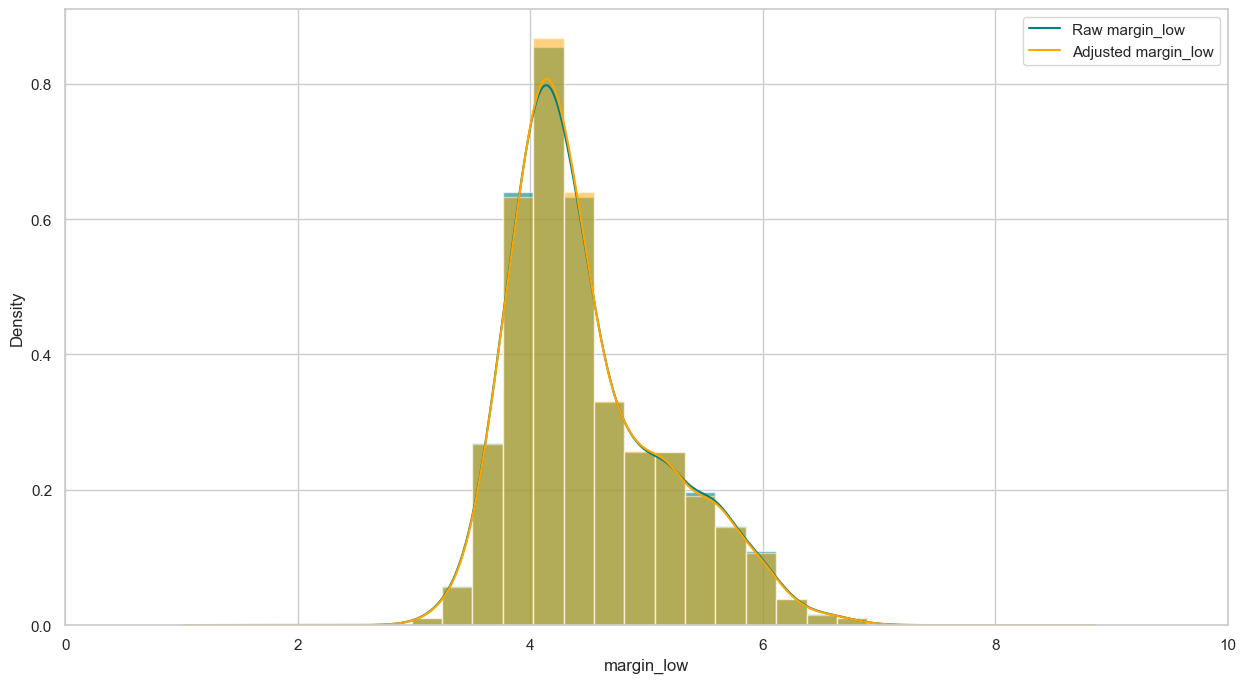

In [190]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_stat["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_stat["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

### 2.3.2 Tests statistiques

Pour confirmer que la distribution, la moyenne et la variance de la colonne 'margin_low' restent les mêmes après l'imputation des valeurs nulles

Distribution test : On peut utiliser un test statistique non paramétrique comme le test de Kolmogorov-Smirnov pour comparer la distribution de la colonne originale avec celle de la colonne remplie.

Test de moyenne : On peut effectuer un test t pour comparer les moyennes de la colonne originale et de la colonne remplie. Assurez-vous que vos données répondent aux hypothèses du test t (distribution normale ou échantillon suffisamment grand).

Test de variance : On peut utiliser un test de F pour comparer les variances de la colonne originale et de la colonne remplie. Encore une fois, assurez-vous que vos données répondent aux hypothèses du test de F (distribution normale ou échantillon suffisamment grand).

In [191]:
df_reg["margin_low"].shape, y_train.shape

((1500,), (1463,))

In [192]:
# Test de distribution
def test_distribution(original, filled):
    _, p_value = stats.ks_2samp(original, filled)
    if p_value < 0.05:
        print(p_value, " -> La distribution n'est pas la même.")
    else:
        print(p_value, " -> La distribution est similaire.")

# Test de moyenne
def test_moyenne(original, filled):
    _, p_value = stats.ttest_ind(original, filled)
    if p_value < 0.05:
        print(p_value, " -> Les moyennes ne sont pas les mêmes.")
    else:
        print(p_value, " -> Les moyennes sont similaires.")

# Test de variance
def test_variance(original, filled):
    _, p_value = stats.levene(original, filled)
    if p_value < 0.05:
        print(p_value, " -> Les variances ne sont pas les mêmes.")
    else:
        print(p_value, " -> Les variances sont similaires.")

# Exécution des tests
test_distribution(y_train, df_reg["margin_low"])
test_moyenne(y_train, df_reg["margin_low"])
test_variance(y_train, df_reg["margin_low"])


1.0  -> La distribution est similaire.
0.9183771668817817  -> Les moyennes sont similaires.
0.8022573628806123  -> Les variances sont similaires.


### - Residuals

In [193]:
X_train_scaled.shape, y_train.shape

((1463, 5), (1463,))

In [194]:
# y_pred = model_1.predict(X_train_scaled)
# residuals = y_train - y_pred
residuals = model_2.resid
residuals

0      -0.268676
1      -0.368908
2       0.274067
3      -0.536580
4      -0.537425
          ...   
1495   -0.771741
1496   -0.186887
1497    0.609723
1498    0.361426
1499   -0.209032
Length: 1463, dtype: float64

<Axes: xlabel='margin_low', ylabel='None'>

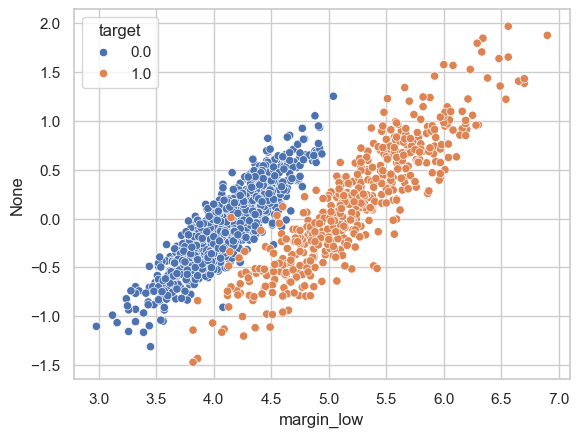

In [195]:
sns.scatterplot(x=train_df.margin_low, y=residuals, hue=train_df.target)

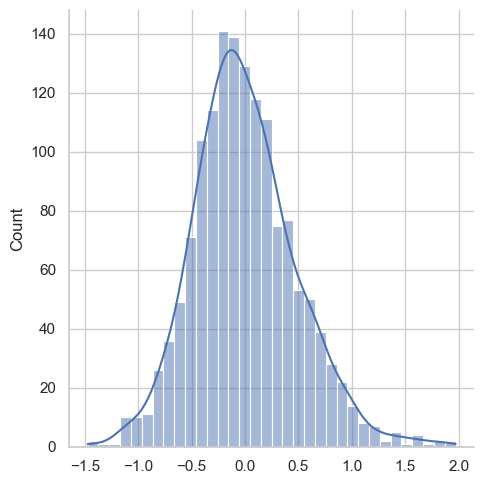

In [196]:
sns.displot(data=residuals, kde=True)
plt.show()


Le test de Shapiro-Wilk est un test statistique utilisé pour déterminer si un échantillon de données suit une distribution normale (gaussienne). Il est basé sur la comparaison entre les moments observés des données et ceux attendus sous l'hypothèse de normalité.

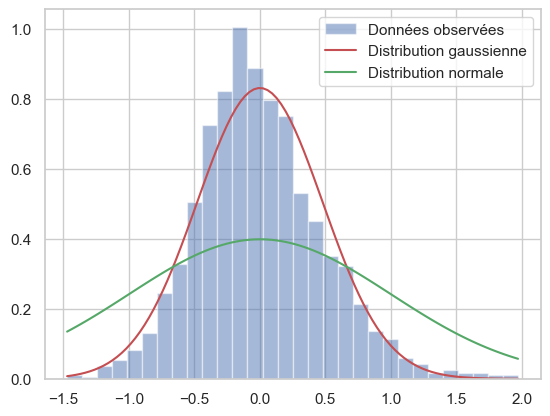

Test de Kolmogorov-Smirnov:
Statistique de test: 0.04278356133056427
P-value: 0.009162802929391665
0.009162802929391665  -> Les résidus ne suivent pas une distribution normale

Test de Shapiro-Wilk:
Statistique de test: 0.9857882577573783
P-value: 8.540407842394512e-11
8.540407842394512e-11  -> Les résidus ne suivent pas une distribution normale


In [197]:
# Calculer la moyenne et la variance
mean = 0
variance = np.var(residuals)

# Créer une distribution normale
normal_dist = stats.norm(loc=0, scale=1)
# Créer une distribution gaussienne
gaussian_dist = stats.norm(loc=mean, scale=np.sqrt(variance))

# Visualiser les données et la distribution gaussienne
plt.hist(residuals, bins=30, density=True, alpha=0.5, label='Données observées')
x = np.linspace(np.min(residuals), np.max(residuals), 100)
plt.plot(x, gaussian_dist.pdf(x), 'r', label='Distribution gaussienne')
plt.plot(x, normal_dist.pdf(x), 'g', label='Distribution normale')
plt.legend()
plt.show()

# Tester l'ajustement
kstest_result = stats.kstest(residuals, 'norm', args=(mean, np.sqrt(variance)))
shapiro_result = stats.shapiro(residuals)

print("Test de Kolmogorov-Smirnov:")
print("Statistique de test:", kstest_result.statistic)
p_value = kstest_result.pvalue
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus ne suivent pas une distribution normale")
else:
    print(p_value, " -> Les résidus suivent une distribution normale")
print("\nTest de Shapiro-Wilk:")
print("Statistique de test:", shapiro_result.statistic)
p_value = shapiro_result.pvalue
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus ne suivent pas une distribution normale")
else:
    print(p_value, " -> Les résidus suivent une distribution normale")


Pour évaluer l'homoscédasticité des résidus, nous utilisons le test statistique de Breusch-Pagan. Ce test compare la variance des résidus avec une ou plusieurs variables indépendantes pour déterminer s'ils présentent une homoscédasticité. En d'autres termes, il examine l'uniformité de la dispersion des résidus sur toute la plage des valeurs prises par les variables indépendantes. <br>L'hétéroscédasticité, qui est le contraire de l'homoscédasticité, se manifeste lorsque la variance des résidus varie de manière non constante à travers les valeurs prédites de la variable dépendante.

In [198]:
# Test de Breusch-Pagan
test_bp = het_breuschpagan(residuals, X_train_scaled_with_const)
print("Test de Breusch-Pagan:")
print("Statistique de test:", test_bp[0])
p_value = test_bp[1]
print("P-value:", p_value)
if p_value < 0.05:
    print(p_value, " -> Les résidus présentent une hétéroscédasticité")
else:
    print(p_value, " -> Les résidus présentent une homoscédasticité")

Test de Breusch-Pagan:
Statistique de test: 80.16261280175414
P-value: 7.759535216181536e-16
7.759535216181536e-16  -> Les résidus présentent une hétéroscédasticité


La multicollinéarité: C'est une condition dans laquelle deux ou plus de deux variables indépendantes (ou prédictives) dans un modèle de régression sont fortement corrélées entre elles. En d'autres termes, il existe une relation linéaire élevée entre au moins deux des variables indépendantes.<br>plusieurs méthodes pour vérifier la multicollinéarité dans un modèle de régression,parmi les quelles:<br>
Variance Inflation Factor (VIF) : Le VIF mesure l'importance de la multicollinéarité dans une régression. Un VIF élevé (généralement supérieur à 10) indique une multicollinéarité problématique.<br>Les variable avec un vif relativement faible contribue de manière unique à expliquer la variation dans la variable dépendante, ce qui est souhaitable dans de nombreux modèles statistiques.

In [199]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train.shape[1])]
print(vif_data, '\n')

seuil = 10 # Un seuil de 10 est couramment utilisé
for index, row in vif_data.iterrows():
    feature = row['feature']
    vif = row['VIF']
    if vif > seuil:
        print(f"La variable '{feature}' a un VIF élevé de {vif:.2f}, ce qui indique une forte corrélation avec d'autres variables explicatives.")
    else:
        print(f"La variable '{feature}' a un VIF de {vif:.2f}, ce qui indique qu'elle est indépendante des autres variables explicatives.")

        feature       VIF
0      diagonal  1.013613
1   height_left  1.138261
2  height_right  1.230115
3     margin_up  1.404404
4        length  1.576950 

La variable 'diagonal' a un VIF de 1.01, ce qui indique qu'elle est indépendante des autres variables explicatives.
La variable 'height_left' a un VIF de 1.14, ce qui indique qu'elle est indépendante des autres variables explicatives.
La variable 'height_right' a un VIF de 1.23, ce qui indique qu'elle est indépendante des autres variables explicatives.
La variable 'margin_up' a un VIF de 1.40, ce qui indique qu'elle est indépendante des autres variables explicatives.
La variable 'length' a un VIF de 1.58, ce qui indique qu'elle est indépendante des autres variables explicatives.


Les valeurs de VIF pour toutes les variables sont inférieures à 10, ce qui suggère qu'il n'y a pas de forte multicollinéarité entre les variables explicatives.<br> Cependant, il est toujours possible que des problèmes de multicollinéarité moins graves puissent influencer les estimations de coefficient dans le modèle.

In [200]:
correlation_matrix = pd.DataFrame(X_train_scaled, columns=X_train.columns).corr()
correlation_matrix

,diagonal,height_left,height_right,margin_up,length
diagonal,1.000000,0.018265,-0.019428,-0.059147,0.100758
height_left,0.018265,1.000000,0.235132,0.243812,-0.314344
height_right,-0.019428,0.235132,1.000000,0.306867,-0.404272
margin_up,-0.059147,0.243812,0.306867,1.000000,-0.521139
length,0.100758,-0.314344,-0.404272,-0.521139,1.000000


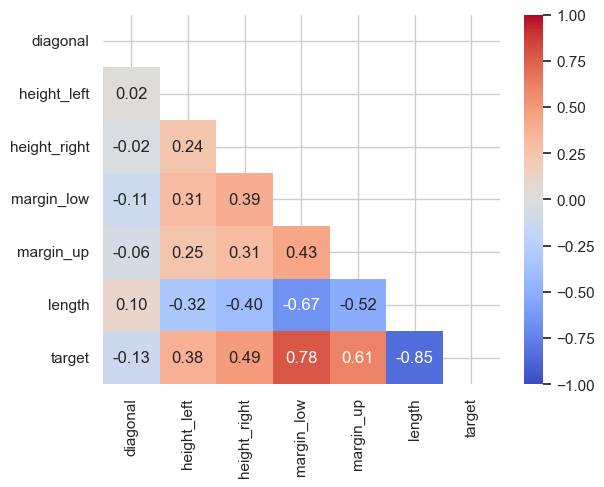

In [201]:
correlation_matrix = df_reg.corr()
masque=np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masque, vmin=-1, vmax=1)
plt.show()

la target est tres correlée avec la longeur des billets et le margin_low
on peut entrainer notre modele en utilisant que ces 2 colonnes et comparer les resultats--> notebook 2

In [202]:
# Calcul des valeurs propres
eigenvalues, _ = np.linalg.eig(correlation_matrix)
eigenvalues

array([3.44745698, 1.01994132, 0.11235063, 0.78939094, 0.71592024,
       0.59150105, 0.32343884])

Il semble que la première variable 'diagonal' contient le plus d'information car elle a la plus grande valeur propre. On doit maintenant choisir une deuxième variable qui est la moins corrélée avec la première.
<br>
En regardant la matrice de corrélation, on voit que la corrélation entre 'diagonal' et 'height_left' est très faible. On peut donc choisir ces deux variables car elles fournissent une information significative et elles ne sont pas fortement corrélées entre elles.

## 3. Exploration des données

## 3.1 visualisation des données

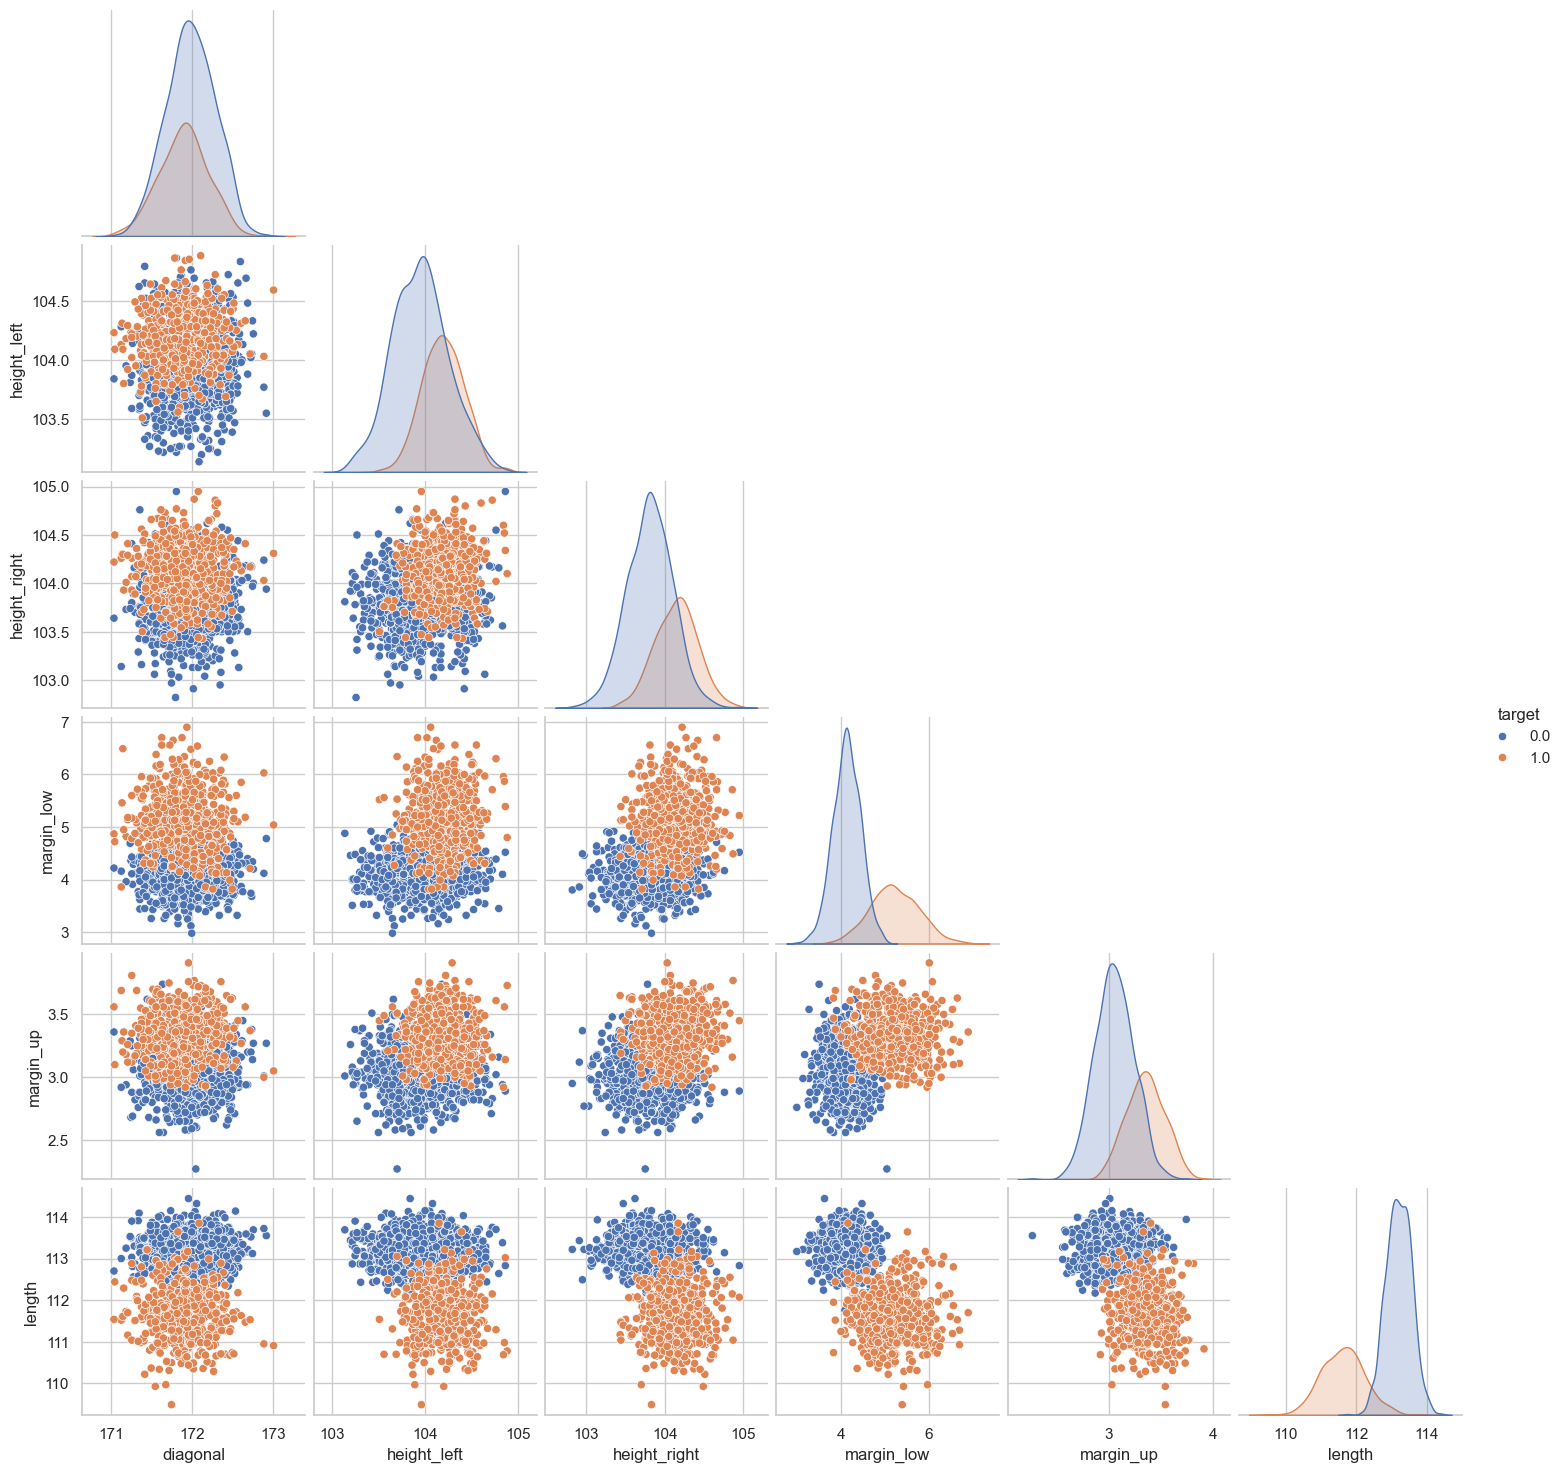

In [203]:
sns.pairplot(df_reg, hue='target', corner=True)
plt.show()

Ce graphique nous montre que la target est corrélée avec la longueur et la margin_low.

## 3.2 Detection des outliers

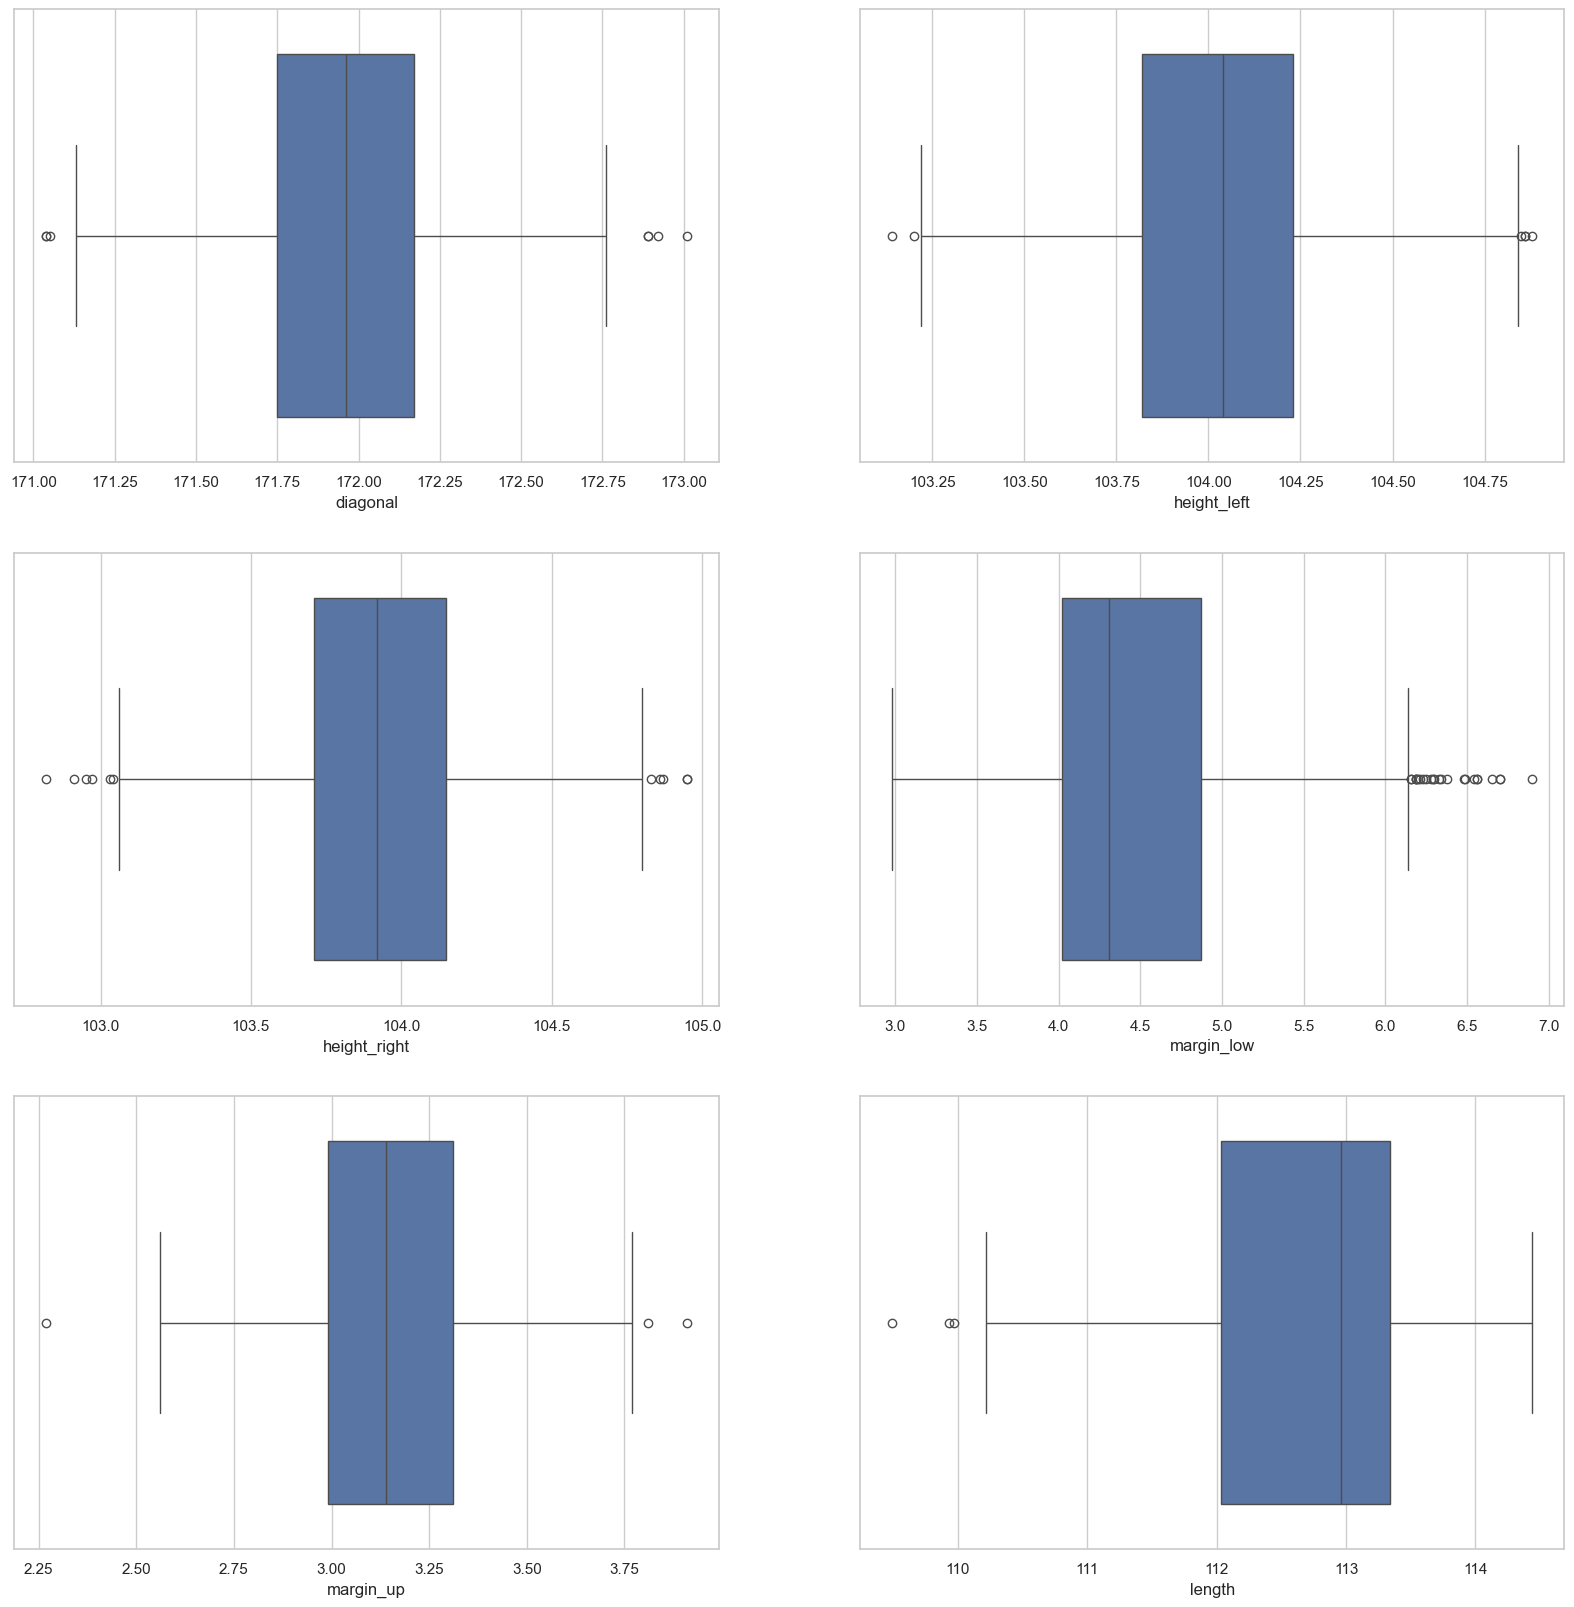

In [204]:
plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")

plt.subplot(321)
sns.boxplot(data=df_reg, x='diagonal')

plt.subplot(322)
sns.boxplot(data=df_reg, x='height_left')

plt.subplot(323)
sns.boxplot(data=df_reg, x='height_right')

plt.subplot(324)
sns.boxplot(data=df_reg, x='margin_low')

plt.subplot(325)
sns.boxplot(data=df_reg, x='margin_up')

plt.subplot(326)
sns.boxplot(data=df_reg, x='length')

plt.show()

Les boxplots révèlent la présence d'outliers dans plusieurs features. <br> Cela suggère que ces valeurs pourraient être liées à des faux billets, caractérisés par des dimensions non conformes, ou bien à des billets de grande valeur, comme les billets de 500€, ou de petites valeurs comme celles de 5€. <br> Ainsi, il est prévu de conserver les outliers afin de poursuivre l'analyse.

## 4. Data mining

Type de données categorielles ---> detection des faux billets

## I. Prédiction de la base de train

## Methodes de prediction 

## 4.1 Choix du modéle

## A. Modelisation avec split <br> 1. Dummy clussifier

In [205]:
X=df_reg.drop(columns='target')
y=df_reg['target']

In [206]:
train_X, test_X, train_y, test_y = train_test_split (X, y, test_size=0.3, random_state=42)

In [207]:
estimator_1= DummyClassifier(strategy="most_frequent")
estimator_1.fit(train_X, train_y)

DummyClassifier(strategy='most_frequent')

In [208]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1[:5]

array([0., 0., 0., 0., 0.])

In [209]:
pd.Series(y_pred_1).value_counts()

0.0    450
Name: count, dtype: int64

In [210]:
test_y.value_counts(normalize=True)

target
0.0    0.642222
1.0    0.357778
Name: proportion, dtype: float64

In [211]:
test_y.value_counts()

target
0.0    289
1.0    161
Name: count, dtype: int64

In [212]:
train_X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
485,171.83,104.29,103.58,4.000000,3.32,113.21
527,171.92,103.79,103.34,3.840000,2.80,113.00
199,171.90,104.42,104.02,4.380000,3.10,112.87
889,172.31,103.94,103.89,4.000000,3.20,113.80
844,171.62,104.14,104.49,4.371811,2.99,113.35


In [213]:
tr_score= estimator_1.score(train_X, train_y)
te_score= estimator_1.score(test_X, test_y)
print(f"le score de train est {tr_score}, et de test est {te_score}")

le score de train est 0.6771428571428572, et de test est 0.6422222222222222


In [214]:
y_pred_1 = estimator_1.predict(test_X)
y_pred_1[:5]

array([0., 0., 0., 0., 0.])

In [215]:
test_y.values

array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0.

In [216]:
1 - abs(y_pred_1 - test_y.values).mean()

0.6422222222222222

In [217]:
mat=confusion_matrix(test_y, y_pred_1, labels=estimator_1.classes_)
mat

array([[289,   0],
       [161,   0]], dtype=int64)

In [218]:
test_y.value_counts()

target
0.0    289
1.0    161
Name: count, dtype: int64

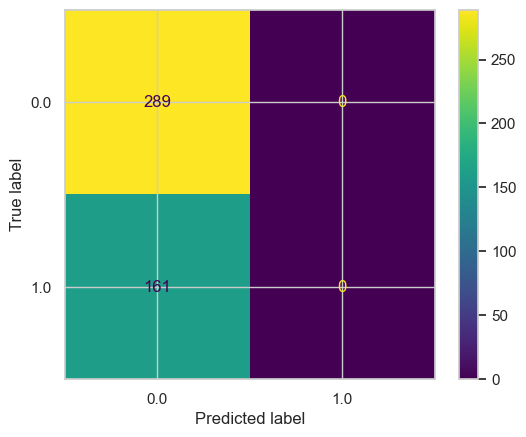

In [219]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels= estimator_1.classes_)
disp.plot()
plt.show()

## 2. Regression logistique

In [220]:
estimator_2 = LogisticRegression(solver='liblinear') #small dataset

In [221]:
estimator_2.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [222]:
y_pred_2=estimator_2.predict(test_X)
y_pred_2[:5]

array([1., 1., 0., 0., 0.])

In [223]:
y_prob = estimator_2.predict_proba(test_X).round(2) #La probabilité de l'appartenance à tel ou tel classe
y_prob[:5]

array([[0.  , 1.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ]])

In [224]:

conf=confusion_matrix(test_y, y_pred_2, labels=estimator_2.classes_)
conf

array([[288,   1],
       [  5, 156]], dtype=int64)

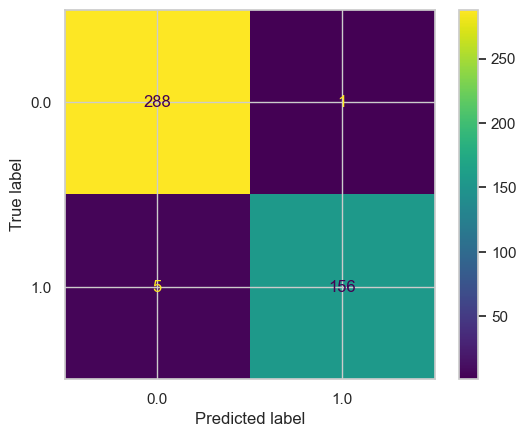

In [225]:

disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels= estimator_2.classes_)
disp.plot()
plt.show()

## 3. SVM

In [226]:
estimator_3 = LinearSVC()

In [227]:
estimator_3.fit(train_X, train_y)

c:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Project-10\.venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Project-10\.venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [228]:
y_pred_3=estimator_3.predict(test_X)
y_pred_3[:5]

array([1., 1., 0., 0., 0.])

In [229]:
conf=confusion_matrix(test_y, y_pred_3, labels=estimator_3.classes_)
conf

array([[289,   0],
       [ 18, 143]], dtype=int64)

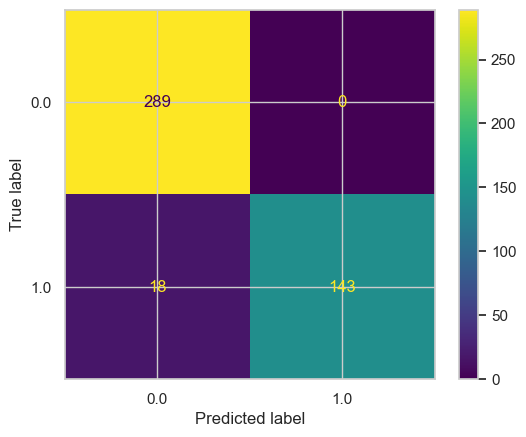

In [230]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels= estimator_3.classes_)
disp.plot()
plt.show()

## B. Modelisation avec cross_validation

In [231]:
X=df_reg.drop(columns=['target'])
y=df_reg['target']

In [232]:
# Création d'une instance de StandardScaler
scaler_2 = StandardScaler()
# Adapter le scaler aux données
scaler_2.fit(X)

# Standardiser les données
X_scaled = scaler_2.transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.30946288, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67253163,  1.41767746,
        -0.15875038]])

In [233]:
#Choix du modele
Logistic_Regression = LogisticRegression()
svc = SVC()
Majority_Model = DummyClassifier(strategy='most_frequent')

# Initialiser les modèles
models = {
    'Logistic Regression': Logistic_Regression,
    'SVC': svc,
    'Majority Model': Majority_Model
}

# La validation croisée et les scores de précision pour chaque modèle
results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    results[model_name] = {'mean_accuracy': scores.mean(), 'std_accuracy': scores.std()}

# Affichage des résultats
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {result['mean_accuracy']}")
    print(f"Standard deviation of Accuracy: {result['std_accuracy']}\n")


Model: Logistic Regression
Mean Accuracy: 0.9906666666666666
Standard deviation of Accuracy: 0.0032659863237109116

Model: SVC
Mean Accuracy: 0.99
Standard deviation of Accuracy: 0.004216370213557866

Model: Majority Model
Mean Accuracy: 0.6666666666666666
Standard deviation of Accuracy: 0.0



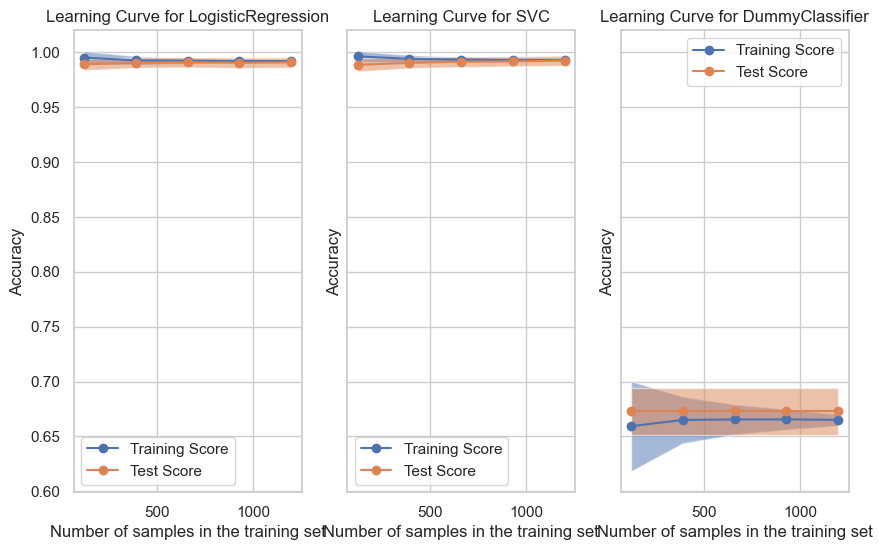

In [234]:
# Évaluation de la performance du modèle

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_scaled,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([Logistic_Regression, svc, Majority_Model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

En observant les courbes d'apprentissage, on peut déterminer que le modèle DummyClassifier montre un sous-apprentissage (underfitting) tandis que les deux modèles Logistic Regression et SVC sont comparables et montrent de bons résultats. <br> On a choisi d'optimiser le modele de Logistic Regression.

In [235]:
#Optimisation des hyperparamètres

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialiser LogisticRegression
logistic_regression = LogisticRegression()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1, return_train_score=True)

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_scaled, y)

# Afficher les meilleurs hyperparamètres et le score associé
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9906666666666666


In [236]:
def resultize(grid_search) : 
    """build a DataFrame from the results of a GridSearchCV"""

    res = pd.DataFrame(grid_search.cv_results_)
    cols = [i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.round(2).iloc[:, 4:].sort_values('mean_test_score', ascending=False)

    return res

In [237]:
resultize(grid_search).head(10)

,param_C,param_penalty,param_solver,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
12,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.99,0.0,8,0.99,0.0
13,1,l1,saga,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,4,0.99,0.0
22,100,l2,liblinear,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.99,0.0,13,0.99,0.0
21,100,l1,saga,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,13,0.99,0.0
20,100,l1,liblinear,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",0.99,0.0,13,0.99,0.0
19,10,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.99,0.0,8,0.99,0.0
18,10,l2,liblinear,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.99,0.0,8,0.99,0.0
17,10,l1,saga,"{'C': 10, 'penalty': 'l1', 'solver': 'saga'}",0.99,0.0,8,0.99,0.0
16,10,l1,liblinear,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.99,0.0,8,0.99,0.0
15,1,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.99,0.0,1,0.99,0.0


In [238]:
#Choisir le bon modele
best_model = grid_search.best_estimator_

In [239]:
#matrice du confusion
y_pred = best_model.predict(X_scaled)
mat=confusion_matrix(y, y_pred)
mat

array([[996,   4],
       [ 10, 490]], dtype=int64)

In [240]:
pd.DataFrame({"y_true" : y, "y_pred" : y_pred})

,y_true,y_pred
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1495,1.0,1.0
1496,1.0,1.0
1497,1.0,1.0
1498,1.0,1.0


<Axes: >

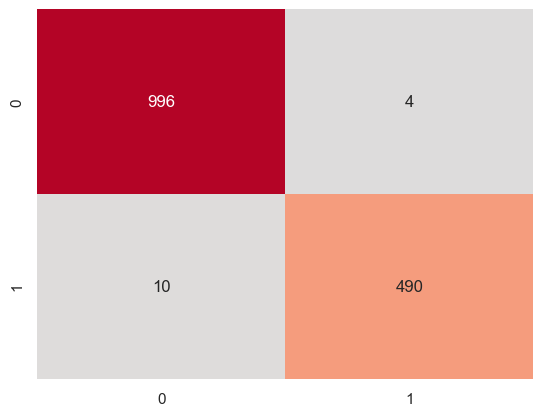

In [241]:
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt='d', cbar=False, vmax=1000, vmin=-1000)

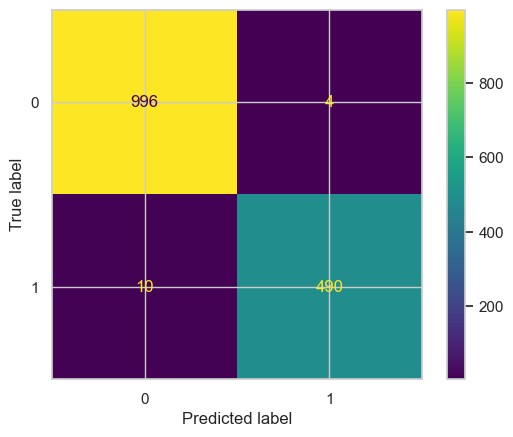

In [242]:
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

On voit que nous avons 10 faux négatifs (10 faux billets classés comme vrais) et 4 faux positifs (4 vrais billets classés comme faux). <br> Nous allons changer la métrique de scoring afin d'avoir moins de faux négatifs.

### Choix metric

accuracy
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.9906666666666666
[[996   4]
 [ 10 490]]


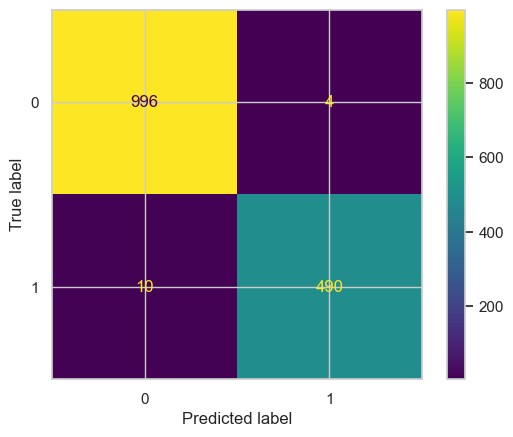

recall
Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.986
[[986  14]
 [  7 493]]


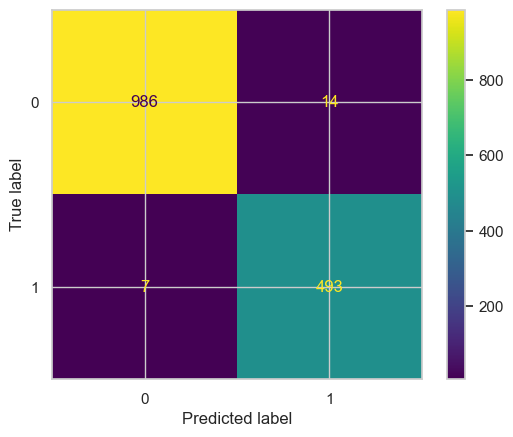

f1
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9859187358010362
[[995   5]
 [  8 492]]


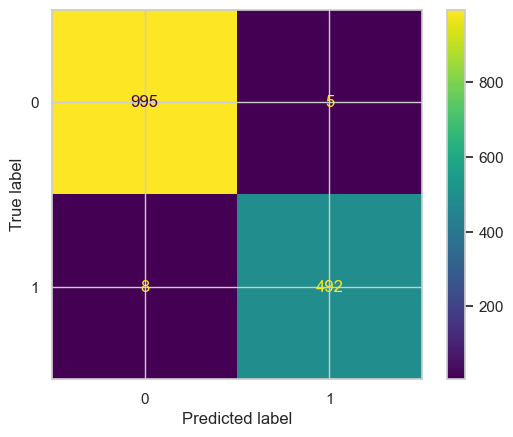

In [243]:
for sco in ['accuracy', 'recall', 'f1']: # , 'roc_auc', 'average_precision'
    print(sco)
    # Définir la grille des hyperparamètres à rechercher
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

    # Initialiser LogisticRegression
    logistic_regression = LogisticRegression()

    # Créer l'objet GridSearchCV
    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring=sco)

    # Exécuter la recherche sur grille sur les données d'entraînement
    grid_search.fit(X_scaled, y)

    # Afficher les meilleurs hyperparamètres et le score associé
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_

    #matrice de confusion
    y_pred = best_model.predict(X_scaled)
    mat=confusion_matrix(y, y_pred)
    print(mat)

    disp = ConfusionMatrixDisplay(confusion_matrix=mat)
    disp.plot()
    plt.show()


On choisit la métrique f1 qui offre le meilleur compromis et le moins de faux négatifs.

### Choix du seuil de décision

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9859187358010362
[[995   5]
 [  8 492]]


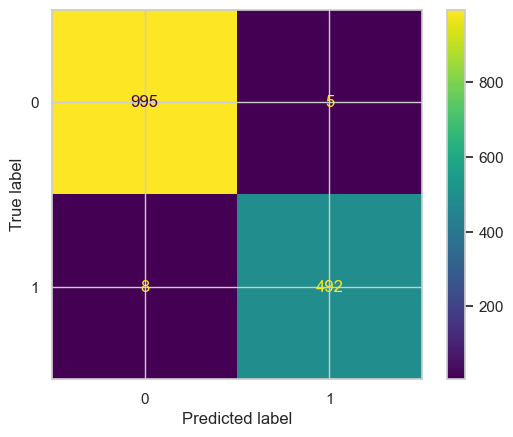

In [244]:
# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialiser LogisticRegression
logistic_regression = LogisticRegression()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='f1')

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_scaled, y)

# Afficher les meilleurs hyperparamètres et le score associé
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

#matrice de confusion
y_pred = best_model.predict(X_scaled)
mat=confusion_matrix(y, y_pred)
print(mat)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()


[[982  18]
 [  3 497]]


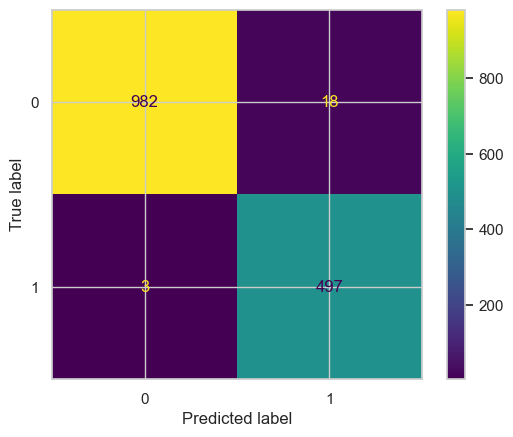

In [245]:
y_proba = best_model.predict_proba(X_scaled)
nouveau_seuil = 0.26
y_pred = (y_proba[:, 1] > nouveau_seuil).astype(int) #Faux billet si la probabilité est supérieure au seuil
mat=confusion_matrix(y, y_pred)
print(mat)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

0.26 est le seuil qui a le meilleur compromis

[[982  18]
 [  3 497]]


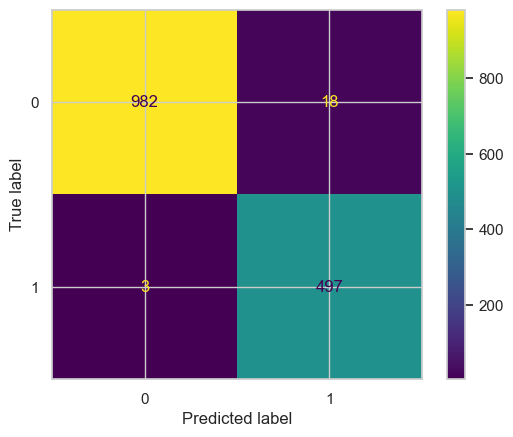

In [246]:
# Créer une fonction de prédiction personnalisée
def predict_with_threshold(X, model=best_model, threshold=0.26):
    # Prédire les probabilités
    y_proba = model.predict_proba(X)
    # Appliquer le seuil personnalisé pour obtenir les classes prédites
    y_pred = (y_proba[:, 1] > threshold).astype(int)
    return y_pred

y_pred = predict_with_threshold(X_scaled)
mat=confusion_matrix(y, y_pred)
print(mat)

disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

## 4. K-means

In [247]:
X_scaled.shape

(1500, 6)

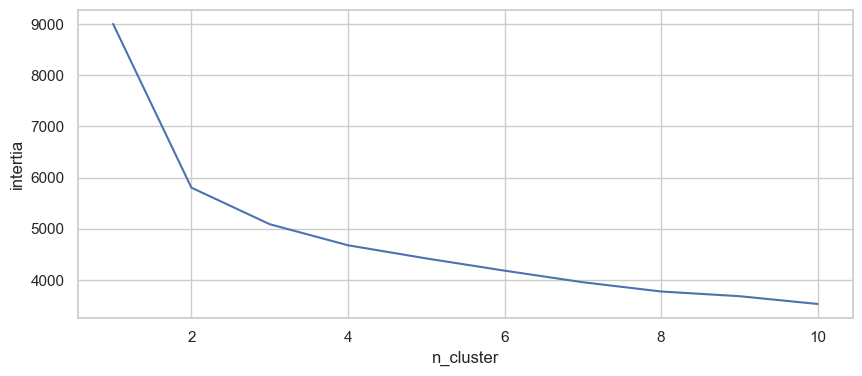

In [248]:
intertia_list = []


k_list = range(1, 11)

for k in k_list : 
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    
    intertia_list.append(kmeans.inertia_)
    
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)

In [249]:
n_clust = 6
kmeans = KMeans(n_clust)
kmeans.fit(X_scaled)
clusters = kmeans.labels_ 
centroids = kmeans.cluster_centers_

In [250]:
df_reg

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0
...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,1.0
1496,172.19,104.63,104.44,5.27,3.37,110.97,1.0
1497,171.80,104.01,104.12,5.51,3.36,111.95,1.0
1498,172.06,104.28,104.06,5.17,3.46,112.25,1.0


In [251]:
df_reg['clusters']=clusters
df_clusters =df_reg.groupby(['clusters','target'])['diagonal'].count().reset_index(name='count')
df_clusters

,clusters,target,count
0,0,0.0,220
1,0,1.0,6
2,1,0.0,1
3,1,1.0,229
4,2,0.0,250
5,3,0.0,286
6,3,1.0,7
7,4,0.0,2
8,4,1.0,252
9,5,0.0,241


In [252]:
# Trier le DataFrame par la colonne count
df_clusters = df_clusters.sort_values(by='count', ascending=False)

# Grouper par cluster et prendre la première ligne de chaque groupe (la ligne avec le max de count)
df_clusters = df_clusters.groupby('clusters').first()
df_clusters

,target,count
clusters,,
0,0.0,220
1,1.0,229
2,0.0,250
3,0.0,286
4,1.0,252
5,0.0,241


In [253]:
df_clusters = df_clusters[['target']]
df_clusters = df_clusters.rename(columns={'target': 'kmeans_pred'})
df_clusters

,kmeans_pred
clusters,
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
5,0.0


In [254]:
if 'kmeans_pred' in list(df_reg):
    df_reg = df_reg.drop(columns=['kmeans_pred'])
df_reg = df_reg.merge(df_clusters, left_on='clusters', right_index=True)
df_reg

,diagonal,height_left,height_right,margin_low,margin_up,length,target,clusters,kmeans_pred
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0,0,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0,2,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0,0,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0,5,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,1.0,1,1.0
1496,172.19,104.63,104.44,5.27,3.37,110.97,1.0,4,1.0
1497,171.80,104.01,104.12,5.51,3.36,111.95,1.0,1,1.0
1498,172.06,104.28,104.06,5.17,3.46,112.25,1.0,4,1.0


Matrice de Confusion:
[[997   3]
 [ 19 481]]


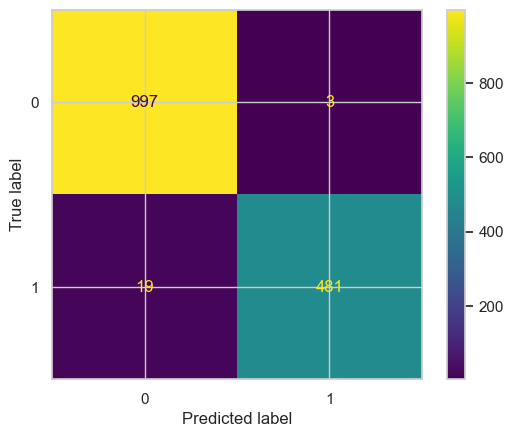


Scores:
Accuracy: 0.9853333333333333
Precision: 0.993801652892562
Recall: 0.962
F1 Score: 0.9776422764227642


In [255]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true = df_reg['target']
y_pred = df_reg['kmeans_pred']

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matrice de Confusion:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

# Calcul des scores
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nScores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Nb clusters: 2
clusters
1    1003
0     497
Name: count, dtype: int64
Matrice de Confusion:
[[990  10]
 [ 13 487]]


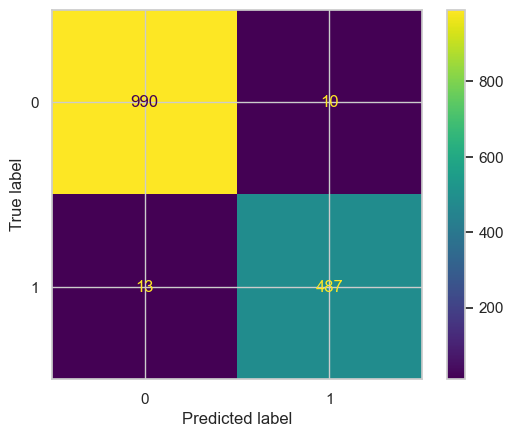


Scores:
Accuracy: 0.9846666666666667
Precision: 0.9798792756539235
Recall: 0.974
F1 Score: 0.9769307923771314

Nb clusters: 3
clusters
2    509
1    503
0    488
Name: count, dtype: int64
Matrice de Confusion:
[[996   4]
 [ 16 484]]


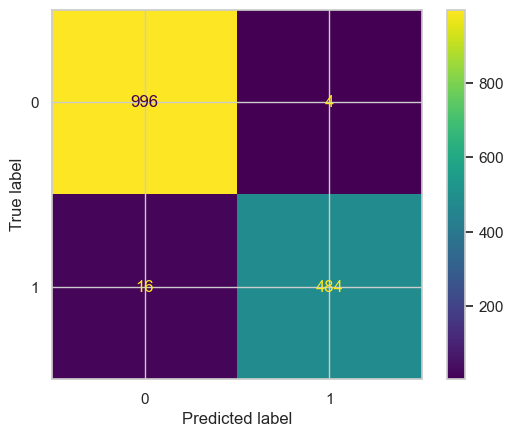


Scores:
Accuracy: 0.9866666666666667
Precision: 0.9918032786885246
Recall: 0.968
F1 Score: 0.979757085020243

Nb clusters: 4
clusters
2    477
1    410
3    368
0    245
Name: count, dtype: int64
Matrice de Confusion:
[[997   3]
 [ 26 474]]


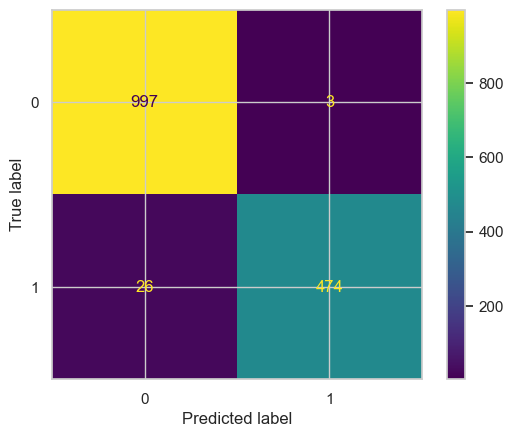


Scores:
Accuracy: 0.9806666666666667
Precision: 0.9937106918238994
Recall: 0.948
F1 Score: 0.970317297850563

Nb clusters: 5
clusters
0    386
3    363
2    267
1    253
4    231
Name: count, dtype: int64
Matrice de Confusion:
[[998   2]
 [ 18 482]]


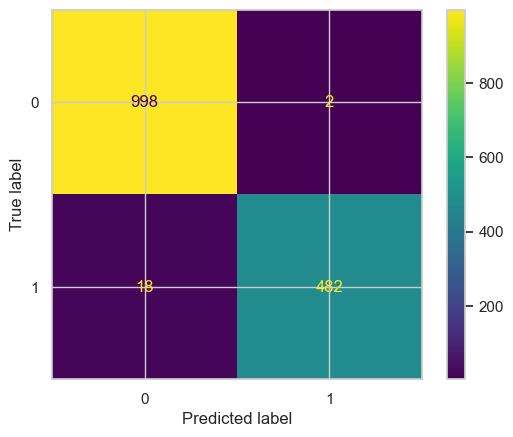


Scores:
Accuracy: 0.9866666666666667
Precision: 0.9958677685950413
Recall: 0.964
F1 Score: 0.9796747967479674

Nb clusters: 6
clusters
0    491
3    489
4    141
1    132
2    124
5    123
Name: count, dtype: int64
Matrice de Confusion:
[[972  28]
 [  8 492]]


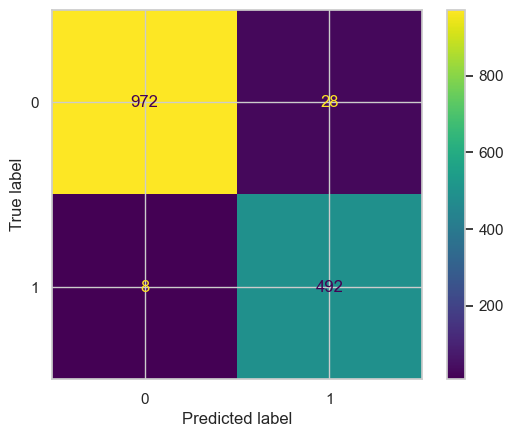


Scores:
Accuracy: 0.976
Precision: 0.9461538461538461
Recall: 0.984
F1 Score: 0.9647058823529412



In [256]:
for k in range(2, 7):
    print(f'Nb clusters: {k}')
    n_clust = k
    kmeans = KMeans(n_clust)
    kmeans.fit(X_scaled)
    clusters = kmeans.labels_ 
    centroids = kmeans.cluster_centers_

    df_reg['clusters']=clusters
    print(df_reg.clusters.value_counts())
    df_clusters =df_reg.groupby(['clusters','target'])['diagonal'].count().reset_index(name='count')
    
    df_clusters = df_clusters.sort_values(by='count', ascending=False)
    df_clusters = df_clusters.groupby('clusters').first()

    df_clusters = df_clusters[['target']]
    df_clusters = df_clusters.rename(columns={'target': 'kmeans_pred'})

    if 'kmeans_pred' in list(df_reg):
        df_reg = df_reg.drop(columns=['kmeans_pred'])
    df_reg = df_reg.merge(df_clusters, left_on='clusters', right_index=True)

  
    y_true = df_reg['target']
    y_pred = df_reg['kmeans_pred']

    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Matrice de Confusion:")
    print(conf_matrix)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()

    # Calcul des scores
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\nScores:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print()

## Conclusion

La regression logistique a un meilleur f1 score avec moins de faux négatifs

## II. Prédiction de la base de test 

In [257]:
test_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [258]:
train_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,target
0,171.81,104.86,104.95,4.52,2.89,112.83,0.0
1,171.46,103.36,103.66,3.77,2.99,113.09,0.0
2,172.69,104.48,103.50,4.40,2.94,113.16,0.0
3,171.36,103.91,103.94,3.62,3.01,113.51,0.0
4,171.73,104.28,103.46,4.04,3.48,112.54,0.0


In [259]:
def preprocess_and_predict(df_test):
    # Vérifier les valeurs manquantes dans la colonne 'margin_low'
    null_indices = df_test['margin_low'].isnull()
    
    # Remplacer les valeurs manquantes dans la colonne 'margin_low' avec les prédictions de model_1 si nécessaire
    if null_indices.any():
        df_test.loc[null_indices, 'margin_low'] = model_1.predict(scaler_1.transform(df_test.loc[null_indices, ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]))
    
    # Appliquer scaler_2 sur les caractéristiques
    scaled_features = scaler_2.transform(df_test[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']])
    
    # Faire des prédictions en utilisant model_2
    predictions = predict_with_threshold(scaled_features)
    
    return predictions

In [261]:
df = test_df.copy(deep=True)

# Appeler la fonction avec les scalers et les modèles appropriés
predictions = preprocess_and_predict(df)

# Ajouter les prédictions au dataframe
df['predictions'] = predictions

df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,predictions
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,1
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,1
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0


In [262]:
# check
df = train_df.sample(10)

# Appeler la fonction avec les scalers et les modèles appropriés
predictions = preprocess_and_predict(df)

# Ajouter les prédictions à votre dataframe ou faire autre chose avec les prédictions
df['predictions'] = predictions

df

,diagonal,height_left,height_right,margin_low,margin_up,length,target,predictions
140,172.47,103.82,103.59,3.850000,2.77,113.17,0.0,0
1176,171.59,104.05,103.94,5.067584,3.02,111.29,1.0,1
217,172.37,104.32,103.52,3.960000,3.11,112.84,0.0,0
1171,171.86,103.94,103.81,5.120000,3.23,111.55,1.0,1
336,171.80,103.96,103.87,3.970000,2.65,112.68,0.0,0
472,171.97,104.04,104.24,4.230000,2.84,113.54,0.0,0
1091,172.20,104.31,104.40,4.600000,3.42,111.92,1.0,1
898,171.95,103.65,103.90,3.980000,3.20,112.68,0.0,0
1004,172.55,104.25,104.23,5.600000,3.13,111.72,1.0,1
498,171.76,104.01,103.68,4.070000,2.75,112.81,0.0,0


## Enregistrement des modèles

In [260]:
import joblib

# Enregistrer les objets dans un fichier
joblib.dump(model_1, 'model_1.pkl')
joblib.dump(scaler_1, 'scaler_1.pkl')
joblib.dump(scaler_2, 'scaler_2.pkl')
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']